# wine_reviews_deeplearning

Continuation of the `wine_reviews` notebook, but now with an applications of Deep Learning NLP methods, such as word embeddings, LSTM etc. <br>
Rybczyński Jędrzej, 17.08.2022

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import SpatialDropout1D, Dropout
from keras.layers import GlobalMaxPooling1D, GlobalMaxPool1D
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Input

from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

## Features Engineering

In [2]:
df = pd.read_csv('wine-reviews.csv')
df = df[['description', 'points']]
df = df.drop_duplicates().reset_index(drop=True)

In [3]:
def points_binning(points):
    if points >= 80 and points <= 84:
        return 1
    elif points >= 85 and points <= 89:
        return 2 
    elif points >= 90 and points <= 94:
        return 3 
    elif points >= 95 and points <= 100:
        return 4
    
df['points'] = df['points'].apply(points_binning)
df

,description,points
0,This tremendous 100% varietal wine hails from ...,4
1,"Ripe aromas of fig, blackberry and cassis are ...",4
2,Mac Watson honors the memory of a wine once ma...,4
3,"This spent 20 months in 30% new French oak, an...",4
4,"This is the top wine from La Bégude, named aft...",4
...,...,...
97826,A Syrah-Grenache blend that's dry and rustical...,1
97827,Oreo eaters will enjoy the aromas of this wine...,1
97828,"Outside of the vineyard, wines like this are w...",1
97829,"Heavy and basic, with melon and pineapple arom...",1


## Text preprocessing

### Lower Casing

In [4]:
df['description'] = df['description'].str.lower()

### Punctuations Removal

In [5]:
import string
import re

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_punctuation_extra(text):
    text = re.sub('[—-]', ' ', text)
    text = re.sub('[”“]', '', text)
    return text

df['description'] = df['description'].apply(remove_punctuation_extra)
df['description'] = df['description'].apply(remove_punctuation)

### Stopwords removal

In [6]:
import nltk

def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    removed = [i for i in text.split() if i not in stopwords]
    return removed

df['description'] = df['description'].apply(remove_stopwords)
df['description'] = df['description'].str.join(' ')

In [7]:
df.head()

,description,points
0,tremendous 100 varietal wine hails oakville ag...,4
1,ripe aromas fig blackberry cassis softened swe...,4
2,mac watson honors memory wine made mother trem...,4
3,spent 20 months 30 new french oak incorporates...,4
4,top wine la bégude named highest point vineyar...,4


## t-SNE EDA

In [8]:
from gensim.models import Word2Vec

desc_tokenized = df.apply(lambda row: nltk.word_tokenize(row['description']), axis=1)
desc_tokenized

0        [tremendous, 100, varietal, wine, hails, oakvi...
1        [ripe, aromas, fig, blackberry, cassis, soften...
2        [mac, watson, honors, memory, wine, made, moth...
3        [spent, 20, months, 30, new, french, oak, inco...
4        [top, wine, la, bégude, named, highest, point,...
                               ...                        
97826    [syrah, grenache, blend, thats, dry, rusticall...
97827    [oreo, eaters, enjoy, aromas, wine, sweet, mil...
97828    [outside, vineyard, wines, like, built, compan...
97829    [heavy, basic, melon, pineapple, aromas, full,...
97830    [smooth, mouth, chard, starts, citrus, dust, a...
Length: 97831, dtype: object

In [9]:
model = Word2Vec(desc_tokenized, vector_size=100, window=20, min_count=2000, workers=4)


print(model)
print(list(model.wv.key_to_index)[:5])
print(model.wv.get_vector('wine'))

Word2Vec(vocab=231, vector_size=100, alpha=0.025)
['wine', 'flavors', 'fruit', 'finish', 'aromas']
[-0.03364231  0.05639113 -0.3587854   0.35995036 -1.2145829  -0.728366
  0.8338217  -0.17638741 -0.6414754   0.2783716   0.6105288   0.04079122
  0.21021523 -0.33287495  0.71687317 -0.21727146  0.05921296 -0.3850311
 -0.7342825  -0.18378524  0.9406321   0.01075758  0.5345052   0.18609475
 -0.4779346  -0.45064646  0.5447719   1.2844748   0.03202605  0.23372266
 -1.3958577  -0.52983797 -0.08992853 -0.12595637 -0.8559465   0.22827742
  0.99082476 -1.178812    0.04455766 -0.18945237  0.23042019  0.99184614
 -0.6031885  -0.8695029  -0.14972936 -0.2456841   0.4667449   1.0900986
 -0.01944505  0.06221655  0.10927016 -0.16906042 -0.5579408  -0.09295561
  0.14373083 -0.6963749  -1.0382607  -0.00610453  0.41581854 -0.1723452
 -0.49869817 -0.11939773 -0.4659573   1.1179283   0.5251013  -0.65269285
  0.1925797   0.17696221  0.86814463 -1.0658282  -0.43916842  0.70428264
  0.92324215  0.36278373 -0.98

In [10]:
from sklearn.manifold import TSNE

def tsne_plot(model):
    "Creates and TSNE model and plots it, source "
    labels = []
    tokens = []

    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\Users\jrybczyn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jrybczyn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


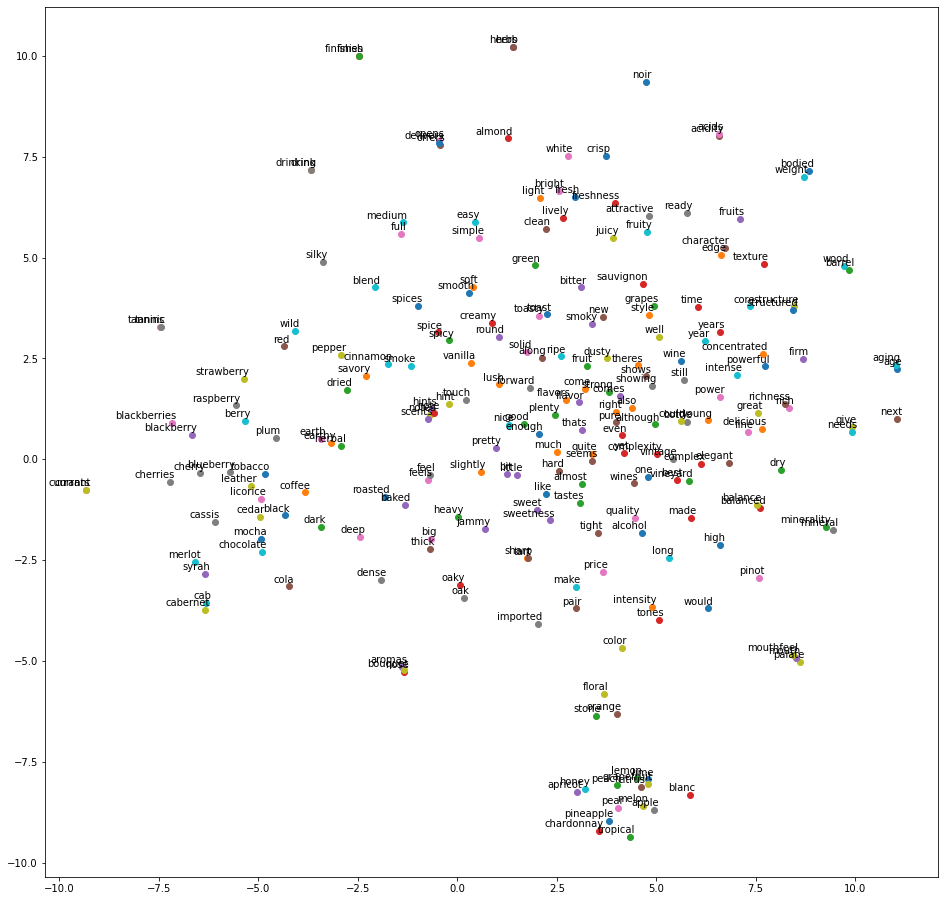

In [11]:
model = Word2Vec(desc_tokenized, vector_size=100, window=20, min_count=2000, workers=4)
tsne_plot(model)

Word2Vec(vocab=149, vector_size=100, alpha=0.025)


C:\Users\jrybczyn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jrybczyn\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


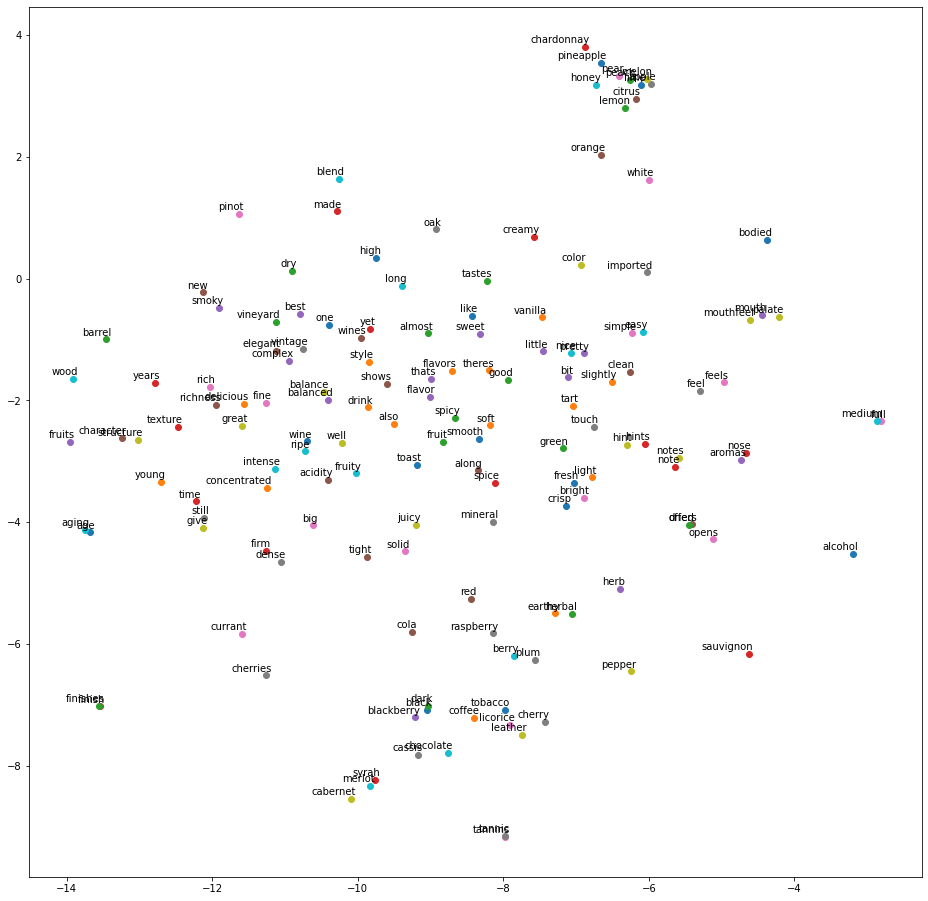

In [12]:
model = Word2Vec(desc_tokenized, vector_size=100, window=20, min_count=3000, workers=4)
print(model)
tsne_plot(model)

## Pretrained Word2Vec Embedding

In [13]:
word2vec_embedding = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
word2vec_embedding

In [14]:
# prepare tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['description'])
VOCAB_SIZE=len(tokenizer.word_index) + 1

# integer encode the documents
encoded_docs = tokenizer.texts_to_sequences(df['description'])

In [15]:
# pad documents
MAX_LENGTH=df['description'].str.split().str.len().max()
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_LENGTH, padding='post')
padded_docs

array([[ 1589,   340,   347, ...,     0,     0,     0],
       [   10,     5,   497, ...,     0,     0,     0],
       [15626, 19904,  6919, ...,     0,     0,     0],
       ...,
       [ 2562,   103,    76, ...,     0,     0,     0],
       [  193,   496,   139, ...,     0,     0,     0],
       [   61,    45,   490, ...,     0,     0,     0]])

In [16]:
# create a weight matrix for words in training docs
EMBEDDING_DIM=300
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if word in word2vec_embedding.key_to_index:
        embedding_matrix[i] = word2vec_embedding[word]

In [17]:
list(tokenizer.word_index)[:15]

['wine',
 'flavors',
 'fruit',
 'finish',
 'aromas',
 'acidity',
 'tannins',
 'cherry',
 'palate',
 'ripe',
 'black',
 'drink',
 'dry',
 'spice',
 'sweet']

In [18]:
X = padded_docs
y = pd.get_dummies(df['points'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## LSTM Neural Network Model (Word2Vec)

In [384]:
model = Sequential()

model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=False))

# model.add(Flatten())

model.add(LSTM(100, return_sequences=True, dropout=0.2))
model.add(GlobalMaxPooling1D())

# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# model.add(Bidirectional(LSTM(50, return_sequences=True)))
# model.add(Bidirectional(LSTM(25, return_sequences=True)))
# model.add(GlobalMaxPool1D())
# model.add(Dropout(0.5))
# model.add(Dense(50, activation='relu', kernel_regularizer='L1L2'))
# model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 83, 300)           9985200   
                                                                 
 lstm (LSTM)                 (None, 83, 100)           160400    
                                                                 
 global_max_pooling1d_8 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_61 (Dense)            (None, 4)                 404       
                                                                 
Total params: 10,146,004
Trainable params: 160,804
Non-trainable params: 9,985,200
_________________________________________________________________


In [385]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [386]:
EPOCHS = 10
BATCH_SIZE = 32
checkpoint = ModelCheckpoint(filepath='model_checkpoint_test.h5',
                             save_format='h5',
                             monitor='val_acc', verbose=1,
                             save_best_only=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2,
    #callbacks=[checkpoint]
)

Epoch 1/10
1957/1957 [==============================] - 530s 270ms/step - loss: 0.7202 - acc: 0.6857 - val_loss: 0.6405 - val_acc: 0.7180
Epoch 2/10
1957/1957 [==============================] - 451s 230ms/step - loss: 0.6378 - acc: 0.7211 - val_loss: 0.6139 - val_acc: 0.7316
Epoch 3/10
1957/1957 [==============================] - 407s 208ms/step - loss: 0.6100 - acc: 0.7327 - val_loss: 0.6055 - val_acc: 0.7319
Epoch 4/10
1957/1957 [==============================] - 394s 201ms/step - loss: 0.5866 - acc: 0.7440 - val_loss: 0.6069 - val_acc: 0.7291
Epoch 5/10
1957/1957 [==============================] - 390s 199ms/step - loss: 0.5658 - acc: 0.7543 - val_loss: 0.5914 - val_acc: 0.7396
Epoch 6/10
1957/1957 [==============================] - 398s 203ms/step - loss: 0.5464 - acc: 0.7626 - val_loss: 0.5961 - val_acc: 0.7386
Epoch 7/10
1957/1957 [==============================] - 414s 211ms/step - loss: 0.5258 - acc: 0.7734 - val_loss: 0.6002 - val_acc: 0.7386
Epoch 8/10
1957/1957 [============

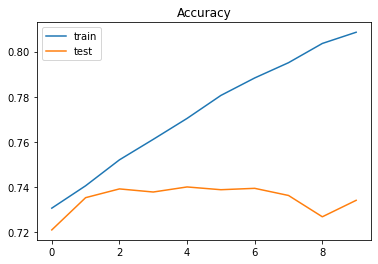

In [25]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

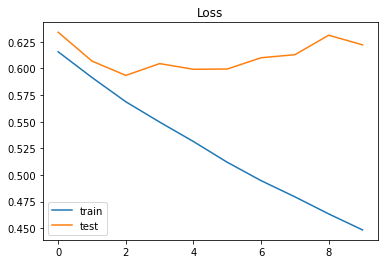

In [26]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [28]:
from keras.models import load_model

model = load_model('model_checkpoint_test.h5')

In [29]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis=1) + 1

print(classification_report(df['points'][y_test.index], prediction))

612/612 [==============================] - 11s 16ms/step
              precision    recall  f1-score   support

           1       0.74      0.66      0.70      2924
           2       0.77      0.77      0.77     10187
           3       0.70      0.76      0.73      6074
           4       0.74      0.13      0.22       382

    accuracy                           0.74     19567
   macro avg       0.74      0.58      0.60     19567
weighted avg       0.74      0.74      0.74     19567



## Pretrained GloVe Embedding

In [313]:
# load the whole embedding into memory
glove_embedding = dict()
f = open('glove.6B/glove.6B.300d.txt', encoding='utf8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embedding[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(glove_embedding))

Loaded 400000 word vectors.


In [314]:
# create a weight matrix for words in training docs
EMBEDDING_DIM=300
embedding_matrix_glove = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if word in glove_embedding.keys():
        embedding_matrix_glove[i] = glove_embedding[word]

## Feedforward Neural Network Model (GloVe)

In [315]:
model = Sequential()

model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix_glove], input_length=MAX_LENGTH, trainable=False))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))

model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 83, 300)           9985200   
                                                                 
 flatten (Flatten)           (None, 24900)             0         
                                                                 
 dense_44 (Dense)            (None, 64)                1593664   
                                                                 
 dropout_531 (Dropout)       (None, 64)                0         
                                                                 
 dense_45 (Dense)            (None, 10)                650       
                                                                 
 dense_46 (Dense)            (None, 4)                 44        
                                                                 
Total params: 11,579,558
Trainable params: 1,594,358
N

In [316]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc', 'mae']
)

In [317]:
EPOCHS = 10
BATCH_SIZE = 32
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    #callbacks=backs=[PlotLossesKeras()]
)

Epoch 1/10
2446/2446 [==============================] - 67s 27ms/step - loss: 0.8566 - acc: 0.6194 - mae: 0.2497 - val_loss: 0.7415 - val_acc: 0.6721 - val_mae: 0.2336
Epoch 2/10
2446/2446 [==============================] - 66s 27ms/step - loss: 0.7513 - acc: 0.6710 - mae: 0.2238 - val_loss: 0.7227 - val_acc: 0.6858 - val_mae: 0.2230
Epoch 3/10
2446/2446 [==============================] - 64s 26ms/step - loss: 0.7100 - acc: 0.6898 - mae: 0.2121 - val_loss: 0.7133 - val_acc: 0.6868 - val_mae: 0.2118
Epoch 4/10
2446/2446 [==============================] - 64s 26ms/step - loss: 0.6782 - acc: 0.7042 - mae: 0.2036 - val_loss: 0.7364 - val_acc: 0.6784 - val_mae: 0.2103
Epoch 5/10
2446/2446 [==============================] - 63s 26ms/step - loss: 0.6474 - acc: 0.7185 - mae: 0.1945 - val_loss: 0.7281 - val_acc: 0.6783 - val_mae: 0.2091
Epoch 6/10
2446/2446 [==============================] - 62s 25ms/step - loss: 0.6205 - acc: 0.7303 - mae: 0.1872 - val_loss: 0.7339 - val_acc: 0.6872 - val_mae:

## LSTM Neural Network Model (GloVe)

In [68]:
model = Sequential()

model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix_glove], input_length=MAX_LENGTH, trainable=False))

model.add(LSTM(100, return_sequences=True, dropout=0.2))
model.add(GlobalMaxPooling1D())

# model.add(SpatialDropout1D(0.2))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# model.add(Bidirectional(LSTM(50, return_sequences=True)))
# model.add(Bidirectional(LSTM(25, return_sequences=True)))
# model.add(GlobalMaxPool1D())
# model.add(Dropout(0.5))
# model.add(Dense(50, activation='relu', kernel_regularizer='L1L2'))
# model.add(Dropout(0.5))

model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 83, 300)           9985200   
                                                                 
 lstm_2 (LSTM)               (None, 83, 100)           160400    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 4)                 404       
                                                                 
Total params: 10,146,004
Trainable params: 160,804
Non-trainable params: 9,985,200
_________________________________________________________________


In [69]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc', 'mae', 'mse']
)

In [70]:
EPOCHS = 10
BATCH_SIZE = 32
#es = EarlyStopping(monitor='val_acc', patience=2, verbose=1, restore_best_weights=True)
history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    #callbacks=[es]
)

Epoch 1/10
 247/2446 [==>...........................] - ETA: 2:33 - loss: 0.8910 - acc: 0.5936 - mae: 0.2653 - mse: 0.1303


KeyboardInterrupt



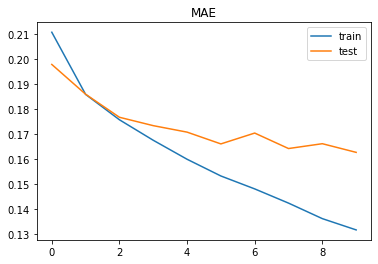

In [34]:
plt.title('MAE')
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
plt.legend()
plt.show();

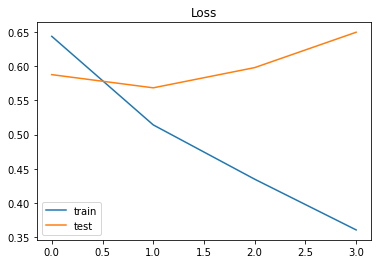

In [25]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [26]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis=1) + 1

print(classification_report(df['points'][y_test.index], prediction))

612/612 [==============================] - 9s 14ms/step
              precision    recall  f1-score   support

           1       0.74      0.66      0.70      2924
           2       0.75      0.83      0.79     10187
           3       0.76      0.70      0.73      6074
           4       0.67      0.27      0.39       382

    accuracy                           0.75     19567
   macro avg       0.73      0.62      0.65     19567
weighted avg       0.75      0.75      0.75     19567



In [27]:
# model.save('lstm_glove')

## Hyperparameter tuning GloVe LSTM NN

In [37]:
import keras_tuner as kt

def model_builder(hp):
    model = Sequential()

    model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix_glove], input_length=MAX_LENGTH, trainable=False))
    
    hp_units = hp.Int('units', min_value=32, max_value=160, step=32)
    hp_dropout = hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)
    model.add(LSTM(units=hp_units, return_sequences=True, dropout=hp_dropout))
    model.add(GlobalMaxPooling1D())

    model.add(Dense(4, activation='softmax'))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=Adam(learning_rate=hp_learning_rate),
        loss='categorical_crossentropy',
        metrics=['acc', 'mae', 'mse'])
    
    return model

In [39]:
tuner = kt.Hyperband(model_builder,
                     objective='val_acc',
                     max_epochs=10,
                     factor=3,
                     directory='hyperband',
                     project_name='wine_reviews_dl')
                     #overwrite=True)

es = EarlyStopping(monitor='val_acc', patience=2, verbose=1, restore_best_weights=True)

In [40]:
tuner.search(X_train, y_train, epochs=15, validation_split=0.2, callbacks=[es])

Trial 30 Complete [01h 05m 41s]
val_acc: 0.7153900265693665

Best val_acc So Far: 0.7509742379188538
Total elapsed time: 05h 58m 51s
INFO:tensorflow:Oracle triggered exit


In [44]:
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 96,
 'dropout': 0.4,
 'learning_rate': 0.001,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0021'}

In [48]:
model = tuner.hypermodel.build(best_hps)
EPOCHS = 30
BATCH_SIZE = 64
checkpoint = ModelCheckpoint(filepath='tuned_lstm_glove.h5',
                             save_format='h5',
                             monitor='val_mae', verbose=1,
                             save_best_only=True)

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint])

Epoch 1/30
1223/1223 [==============================] - ETA: 0s - loss: 0.7310 - acc: 0.6772 - mae: 0.2211 - mse: 0.1095
Epoch 1: val_mae improved from inf to 0.20154, saving model to tuned_lstm_glove.h5
1223/1223 [==============================] - 184s 148ms/step - loss: 0.7310 - acc: 0.6772 - mae: 0.2211 - mse: 0.1095 - val_loss: 0.6574 - val_acc: 0.7110 - val_mae: 0.2015 - val_mse: 0.0998
Epoch 2/30
1223/1223 [==============================] - ETA: 0s - loss: 0.6444 - acc: 0.7182 - mae: 0.1965 - mse: 0.0978
Epoch 2: val_mae improved from 0.20154 to 0.18502, saving model to tuned_lstm_glove.h5
1223/1223 [==============================] - 182s 149ms/step - loss: 0.6444 - acc: 0.7182 - mae: 0.1965 - mse: 0.0978 - val_loss: 0.6115 - val_acc: 0.7307 - val_mae: 0.1850 - val_mse: 0.0932
Epoch 3/30
1223/1223 [==============================] - ETA: 0s - loss: 0.6134 - acc: 0.7324 - mae: 0.1872 - mse: 0.0932
Epoch 3: val_mae improved from 0.18502 to 0.18179, saving model to tuned_lstm_glove.h

1223/1223 [==============================] - 223s 182ms/step - loss: 0.4628 - acc: 0.8021 - mae: 0.1410 - mse: 0.0704 - val_loss: 0.6028 - val_acc: 0.7459 - val_mae: 0.1590 - val_mse: 0.0909
Epoch 23/30
1223/1223 [==============================] - ETA: 0s - loss: 0.4617 - acc: 0.8039 - mae: 0.1403 - mse: 0.0700
Epoch 23: val_mae did not improve from 0.15904
1223/1223 [==============================] - 199s 163ms/step - loss: 0.4617 - acc: 0.8039 - mae: 0.1403 - mse: 0.0700 - val_loss: 0.6254 - val_acc: 0.7378 - val_mae: 0.1627 - val_mse: 0.0941
Epoch 24/30
1223/1223 [==============================] - ETA: 0s - loss: 0.4552 - acc: 0.8064 - mae: 0.1388 - mse: 0.0692
Epoch 24: val_mae did not improve from 0.15904
1223/1223 [==============================] - 182s 149ms/step - loss: 0.4552 - acc: 0.8064 - mae: 0.1388 - mse: 0.0692 - val_loss: 0.6296 - val_acc: 0.7337 - val_mae: 0.1617 - val_mse: 0.0945
Epoch 25/30
1223/1223 [==============================] - ETA: 0s - loss: 0.4520 - acc: 0.

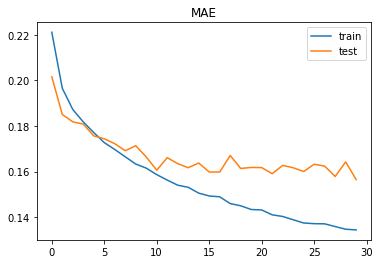

In [49]:
plt.title('MAE')
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='test')
plt.legend()
plt.show();

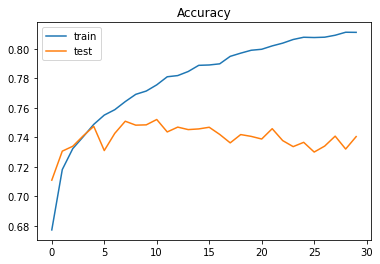

In [50]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [52]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis=1) + 1

print(classification_report(df['points'][y_test.index], prediction))

612/612 [==============================] - 16s 25ms/step
              precision    recall  f1-score   support

           1       0.74      0.62      0.67      2924
           2       0.76      0.79      0.77     10187
           3       0.72      0.74      0.73      6074
           4       0.51      0.36      0.42       382

    accuracy                           0.74     19567
   macro avg       0.68      0.63      0.65     19567
weighted avg       0.74      0.74      0.74     19567



In [66]:
val_acc_per_epoch = history.history['val_acc']
best_epoch_acc = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
best_epoch_acc

11

In [67]:
model = tuner.hypermodel.build(best_hps)
EPOCHS = best_epoch_acc
BATCH_SIZE = 64

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test))

Epoch 1/11
1223/1223 [==============================] - 197s 159ms/step - loss: 0.7330 - acc: 0.6765 - mae: 0.2215 - mse: 0.1097 - val_loss: 0.6366 - val_acc: 0.7215 - val_mae: 0.1982 - val_mse: 0.0968
Epoch 2/11
1223/1223 [==============================] - 254s 207ms/step - loss: 0.6428 - acc: 0.7177 - mae: 0.1962 - mse: 0.0977 - val_loss: 0.6207 - val_acc: 0.7247 - val_mae: 0.1883 - val_mse: 0.0949
Epoch 3/11
1223/1223 [==============================] - 245s 200ms/step - loss: 0.6181 - acc: 0.7297 - mae: 0.1889 - mse: 0.0941 - val_loss: 0.5974 - val_acc: 0.7386 - val_mae: 0.1846 - val_mse: 0.0912
Epoch 4/11
1223/1223 [==============================] - 249s 203ms/step - loss: 0.5957 - acc: 0.7402 - mae: 0.1820 - mse: 0.0907 - val_loss: 0.6211 - val_acc: 0.7282 - val_mae: 0.1834 - val_mse: 0.0951
Epoch 5/11
1223/1223 [==============================] - 242s 198ms/step - loss: 0.5799 - acc: 0.7489 - mae: 0.1769 - mse: 0.0882 - val_loss: 0.5898 - val_acc: 0.7427 - val_mae: 0.1757 - val_ms

In [68]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis=1) + 1

print(classification_report(df['points'][y_test.index], prediction))

612/612 [==============================] - 28s 41ms/step
              precision    recall  f1-score   support

           1       0.73      0.67      0.70      2924
           2       0.78      0.75      0.77     10187
           3       0.70      0.79      0.74      6074
           4       0.57      0.37      0.45       382

    accuracy                           0.74     19567
   macro avg       0.70      0.65      0.66     19567
weighted avg       0.74      0.74      0.74     19567



## Under-Sampling Attempt

In [122]:
X_rus = df['description']
y_rus = df['points']
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.2,
                                                                    stratify=y_rus, random_state=42)

In [123]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train_rus)
y_train_rus = pd.get_dummies(y_train_rus)

In [134]:
model = Sequential()

model.add(Embedding(VOCAB_SIZE, EMBEDDING_DIM, weights=[embedding_matrix_glove], input_length=MAX_LENGTH, trainable=False))

model.add(Flatten())
model.add(Dense(64, activation='relu'))

model.add(Dense(4, activation='softmax'))

# model.summary()

In [135]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['acc', 'mae']
)

In [136]:
EPOCHS = 10
BATCH_SIZE = 32
history = model.fit(
    X_train_rus,
    y_train_rus,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1
)

Epoch 1/10
172/172 [==============================] - 4s 22ms/step - loss: 1.3821 - acc: 0.2787 - mae: 0.3711 - val_loss: 1.7016 - val_acc: 0.0033 - val_mae: 0.4077
Epoch 2/10
172/172 [==============================] - 3s 18ms/step - loss: 1.2275 - acc: 0.4929 - mae: 0.3471 - val_loss: 1.7813 - val_acc: 0.0392 - val_mae: 0.4112
Epoch 3/10
172/172 [==============================] - 4s 22ms/step - loss: 1.0439 - acc: 0.6453 - mae: 0.3124 - val_loss: 1.8739 - val_acc: 0.0408 - val_mae: 0.4162
Epoch 4/10
172/172 [==============================] - 4s 22ms/step - loss: 0.8578 - acc: 0.7702 - mae: 0.2733 - val_loss: 2.0089 - val_acc: 0.0359 - val_mae: 0.4221
Epoch 5/10
172/172 [==============================] - 3s 19ms/step - loss: 0.6992 - acc: 0.8557 - mae: 0.2357 - val_loss: 2.0296 - val_acc: 0.0784 - val_mae: 0.4182
Epoch 6/10
 97/172 [===============>..............] - ETA: 1s - loss: 0.5664 - acc: 0.9127 - mae: 0.2010

KeyboardInterrupt: 

## Learning own Embedding

It was trained on Azure ML studio, only loading model.

In [135]:
from keras.models import load_model

model = load_model('own_embb_model/') 

In [134]:
prediction = model.predict(X_test)
prediction = np.argmax(prediction, axis=1) + 1

print(classification_report(df['points'][y_test.index], prediction))

612/612 [==============================] - 36s 59ms/step
              precision    recall  f1-score   support

           1       0.69      0.61      0.65      2924
           2       0.73      0.78      0.75     10187
           3       0.71      0.66      0.68      6074
           4       0.42      0.37      0.40       382

    accuracy                           0.71     19567
   macro avg       0.64      0.61      0.62     19567
weighted avg       0.71      0.71      0.71     19567



## Stacking CatBoost & LSTM GloVe attempt

In [42]:
from catboost import CatBoostClassifier

cb = CatBoostClassifier()
cb.load_model('catboost_model')

In [43]:
df_catboost = pd.read_pickle('catboost_df')

X = df_catboost.drop(columns='points')
y = df_catboost['points']
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_catboost['description'])
VOCAB_SIZE=len(tokenizer.word_index) + 1

encoded_docs = tokenizer.texts_to_sequences(df_catboost['description'])
MAX_LENGTH=df_catboost['description'].str.split().str.len().max()
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_LENGTH, padding='post')

X = padded_docs
y = pd.get_dummies(df_catboost['points'])
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [45]:
cb_pred_proba = cb.predict_proba(X_test_cb)
lstm_pred_proba = model.predict(X_test_lstm)

612/612 [==============================] - 11s 18ms/step


In [46]:
stacking_pred_proba = 0.9 * cb_pred_proba + 0.1 * lstm_pred_proba
prediction = np.argmax(stacking_pred_proba, axis=1) + 1

In [38]:
y_test_merged = y_test.merge(y_test_cb, left_index=True, right_index=True, how='inner')
y_test_merged = y_test_merged['points'].sort_index()

X_test_lstm = pd.DataFrame(X_test, index=y_test.index)
X_test_lstm = X_test_lstm[X_test_lstm.index.isin(y_test_merged.index)].sort_index()
X_test_lstm = X_test_lstm.to_numpy()

X_test_cb = X_test_cb[X_test_cb.index.isin(y_test_merged.index)].sort_index()

cb_pred_proba = cb.predict_proba(X_test_cb)
lstm_pred_proba = model.predict(X_test_lstm)

stacking_pred_proba = 0.7 * cb_pred_proba + 0.3 * lstm_pred_proba
prediction = np.argmax(stacking_pred_proba, axis=1) + 1

print(classification_report(y_test_merged, prediction))

125/125 [==============================] - 3s 18ms/step
              precision    recall  f1-score   support

           1       0.85      0.64      0.73       583
           2       0.79      0.87      0.83      2075
           3       0.79      0.78      0.79      1250
           4       0.80      0.32      0.45        76

    accuracy                           0.80      3984
   macro avg       0.81      0.65      0.70      3984
weighted avg       0.80      0.80      0.79      3984



## BERT (`TFBertModel` from HuggingFace)

In [49]:
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [50]:
bert_model.layers[0].trainable = False
bert_model.summary()

Model: "tf_bert_model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 0
Non-trainable params: 109,482,240
_________________________________________________________________


In [45]:
def bert_encode(X, tokenizer):
    enc_dict = tokenizer.batch_encode_plus(X,
    max_length=MAX_LENGTH, # set the length of the sequences
    truncation=True,
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    return_token_type_ids=False, # not needed for this type of ML task
    pad_to_max_length=True) # add 0 pad tokens to the sequences less than max_length
    #return_tensors='tf')
    
    return np.array(enc_dict['input_ids']), np.array(enc_dict['attention_mask'])

In [46]:
X = df['description']
y = pd.get_dummies(df['points'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

X_train_ids, X_train_mask = bert_encode(X_train, tokenizer)
X_test_ids, X_test_mask = bert_encode(X_test, tokenizer)

In [51]:
def create_model(bert_model):    
    # This is the input for the tokens themselves(words from the dataset after encoding):
    input_ids = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids')

    # attention_mask - is a binary mask which tells BERT which tokens to attend and which not to attend.
    # Encoder will add the 0 tokens to the some sequence which smaller than MAX_SEQUENCE_LENGTH, 
    # and attention_mask, in this case, tells BERT where is the token from the original data and where is 0 pad token:
    attention_mask = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32, name='attention_mask')
    
    # Use previous inputs as BERT inputs:
    output = bert_model([input_ids, attention_mask])[1]

    # We can also add dropout as regularization technique:
    #output = tf.keras.layers.Dropout(rate=0.15)(output)

    # Provide number of classes to the final layer:
    output = Dense(4, activation='softmax')(output)

    # Final model:
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    # Compile the model:
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['acc', 'mae', 'mse'])
    
    return model

In [52]:
model = create_model(bert_model)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 83)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 83)]         0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 83,                                          

In [54]:
EPOCHS = 3
BATCH_SIZE = 32
# checkpoint = ModelCheckpoint(filepath='bert_model.h5',
#                              save_format='h5',
#                              monitor='val_acc', verbose=1,
#                              save_best_only=True)

history = model.fit(
    x=[X_train_ids, X_train_mask],
    y=y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    #callbacks=[checkpoint]
)

## BERT v2 (`TFBertForSequenceClassification` from HuggingFace)

In [58]:
from transformers import BertTokenizer, TFBertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
bert_model.layers[0].trainable = False
# for layer in bert_model.layers:
#     layer.trainable = False
bert_model.summary()

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_298 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
Total params: 109,485,316
Trainable params: 3,076
Non-trainable params: 109,482,240
_________________________________________________________________


In [60]:
def bert_encode(X, tokenizer):
    enc_dict = tokenizer.batch_encode_plus(X,
    max_length=MAX_LENGTH, # set the length of the sequences
    truncation=True,
    add_special_tokens=True, # add [CLS] and [SEP] tokens
    return_attention_mask=True,
    return_token_type_ids=False, # not needed for this type of ML task
    pad_to_max_length=True) # add 0 pad tokens to the sequences less than max_length
    #return_tensors='tf')
    
    return np.array(enc_dict['input_ids']), np.array(enc_dict['attention_mask'])

In [61]:
X = df['description']
y = pd.get_dummies(df['points'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

X_train_ids, X_train_mask = bert_encode(X_train, tokenizer)
X_test_ids, X_test_mask = bert_encode(X_test, tokenizer)

In [62]:
def create_model(bert_model):    
    # This is the input for the tokens themselves(words from the dataset after encoding):
    input_ids = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids')

    # attention_mask - is a binary mask which tells BERT which tokens to attend and which not to attend.
    # Encoder will add the 0 tokens to the some sequence which smaller than MAX_SEQUENCE_LENGTH, 
    # and attention_mask, in this case, tells BERT where is the token from the original data and where is 0 pad token:
    attention_mask = tf.keras.layers.Input((MAX_LENGTH,), dtype=tf.int32, name='attention_mask')
    
    # Use previous inputs as BERT inputs:
    output = bert_model([input_ids, attention_mask])[0]

    # We can also add dropout as regularization technique:
    #output = tf.keras.layers.Dropout(rate=0.15)(output)

    # Provide number of classes to the final layer:
    #output = Dense(4, activation='softmax')(output)

    # Final model:
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    
    # Compile the model:
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['acc', 'mae', 'mse'])
    
    return model

In [63]:
model = create_model(bert_model)
# model.layers[2].trainable = False
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 83)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 83)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109485316  ['input_ids[0][0]',              
 ation_2 (TFBertForSequenceClas  rOutput(loss=None,               'attention_mask[0][0]']         
 sification)                    logits=(None, 4),                                                 
                                 hidden_states=None                                         

In [30]:
EPOCHS = 3
BATCH_SIZE = 32
# checkpoint = ModelCheckpoint(filepath='bert_model.h5',
#                              save_format='h5',
#                              monitor='val_acc', verbose=1,
#                              save_best_only=True)

history = model.fit(
    x=[X_train_ids, X_train_mask],
    y=y_train,
    validation_data=([X_test_ids, X_test_mask], y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    #callbacks=[checkpoint]
)

Epoch 1/3
2446/2446 [==============================] - 150784s 62s/step - loss: 0.9437 - acc: 0.5780 - mae: 0.2754 - mse: 0.1371 - val_loss: 0.9002 - val_acc: 0.6087 - val_mae: 0.2613 - val_mse: 0.1303
Epoch 2/3
2446/2446 [==============================] - 173620s 71s/step - loss: 0.8893 - acc: 0.6039 - mae: 0.2616 - mse: 0.1307 - val_loss: 0.8436 - val_acc: 0.6219 - val_mae: 0.2500 - val_mse: 0.1248
Epoch 3/3
2446/2446 [==============================] - 11258s 5s/step - loss: 0.8745 - acc: 0.6092 - mae: 0.2580 - mse: 0.1290 - val_loss: 0.8419 - val_acc: 0.6272 - val_mae: 0.2529 - val_mse: 0.1249
